# Chapter 11 - Implementing a Multilayer Artificial Neural Network From Scratch

## Modeling Complex Functions With Artificial Neural Networks

### Single Layer Neural Retwork Recap

![Alt text](../images/26.png)

### Introducing The Multilayer Neural Network Architecture

![Alt text](../images/27.png)

The MLP in the graph has one hidden layer and one output layer. The units in the hiden layer are fully connected to the input features, and the output layer is fully connected to the hidden layer. If such a network has more than one hidden layer, we also call it a **deep NN**. 

Let's summarize the MLP learning procedure in three simple steps:

1. Starting at the input layer, we forward propagate the patterns of the training data through the network to generate an output.

2. Based on the network's output, we calculate the loss that we want to minimize using a loss function that we will describe later.

3. We backpropagate the loss, find its derivative with respect to each weight and bias unit in the network, and update the model.

Finally, we repeat these three steps for multiple epochs and learn the weight and bias parameters of the MLP, we use forward propagation to calculate the network output and apply  threshold function to obtain the predicted class albels in the one-hot representation.

## Classifying Handwritten Digits

In [17]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [18]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [19]:
# Normalize the data to be between -1 and 1, because granient-based optimization is more stable 
# when the data is normalized

X = ((X / 255.) - .5) * 2

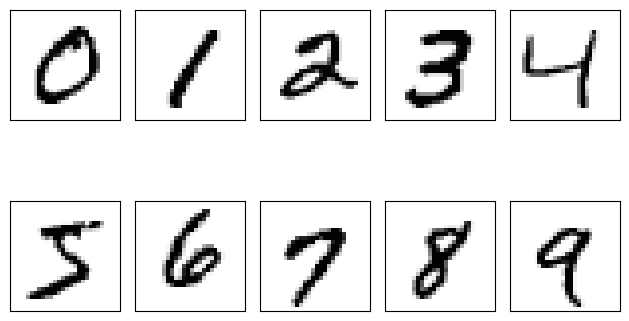

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()

for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

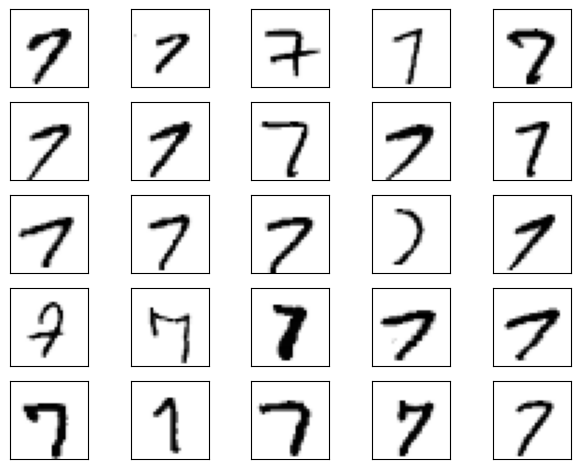

In [21]:
fig, ax = plt.subplots(nrows=5,
                        ncols=5,
                        sharex=True,
                        sharey=True)
ax = ax.flatten()

for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [22]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=10000, random_state=123, stratify=y
        )

X_train, X_valid, y_train, y_valid = train_test_split(
                                        X_temp, y_temp, test_size=5000,
                                        random_state=123, stratify=y_temp
            )

### Implementing a Multilayer Perceptron

In [23]:
import numpy as np

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    
    return ary

In [24]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()  
        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
                    loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
                    loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer

        # input dim: [n_hidden, n_features]
        # dot [n_features, n_examples] .T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)
        # Output layer
        # input dim: [n_classes, n_hidden]
        # dot [n_hidden, n_examples] .T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        #########################
        ### Output layer weights
        #########################

        # one-hot encoding
        y_onehot = int_to_onehot(y, self.num_classes)
        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative
        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out
        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples]
        # dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet
        # * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T,
        d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)
        return (d_loss__dw_out, d_loss__db_out,
        d_loss__d_w_h, d_loss__d_b_h)

In [25]:
model = NeuralNetMLP(num_features=28*28,
                    num_hidden=50,
                    num_classes=10)

![Alt text](../images/28.png)


### Coding the NN Training Loop

In [26]:
import numpy as np
num_epochs = 50
minibatch_size = 100
def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [27]:
# iterate over training epochs
for i in range(num_epochs):
    # iterate over minibatches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [28]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(
    targets, num_labels=num_labels
    )
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [29]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f'Initial validation MSE: {mse:.1f}')

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.4%


In [30]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(
        targets, num_labels=num_labels
        )
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [31]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.4%


In [32]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)
            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, \
            d_loss__d_w_h, d_loss__d_b_h = \
            model.backward(X_train_mini, a_h, a_out,
            y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(
        model, X_train, y_train
        )
        valid_mse, valid_acc = compute_mse_and_acc(
        model, X_valid, y_valid
        )
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
                f'| Train MSE: {train_mse:.2f} '
                f'| Train Acc: {train_acc:.2f}% '
                f'| Valid Acc: {valid_acc:.2f}%')

        return epoch_loss, epoch_train_acc, epoch_valid_acc

In [33]:
np.random.seed(123) # for the training set shuffling
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%


### Evaluating The Neural Network Performance

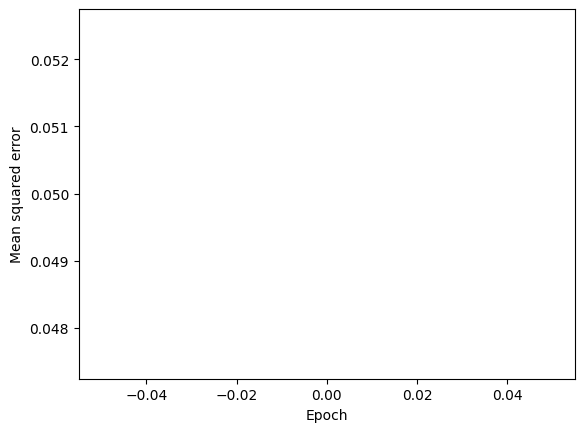

In [34]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

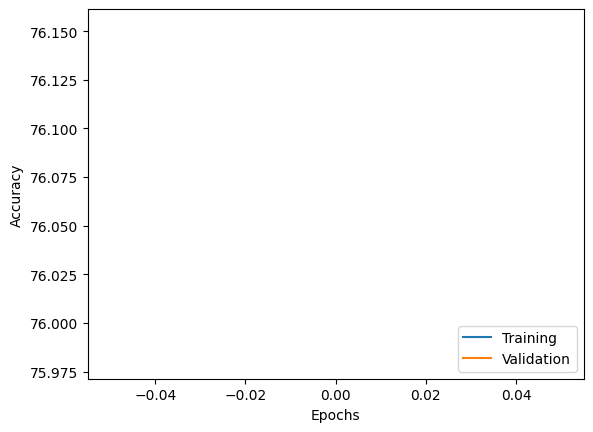

In [35]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [36]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 76.00%


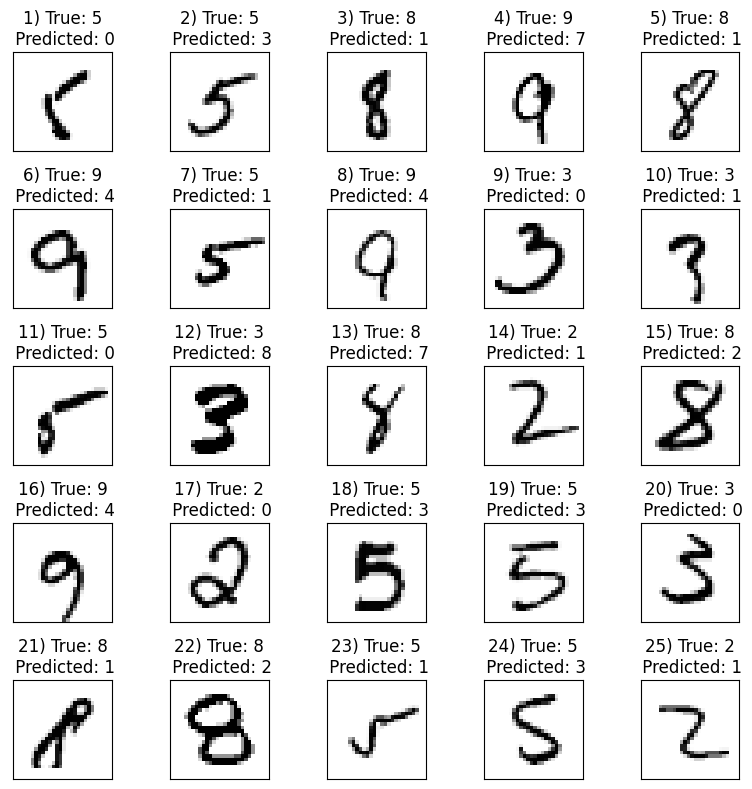

In [37]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5,
sharex=True, sharey=True,
figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

## Training An Artificial Neural Network

### Developing An Understanding Of Backpropagation

In essence, we can think of backpropagation as veru computationally efficient approach to compute the partial derivatives of a complex, non-convex los function in multilayer NNs. Our goal is to use those erivatives to learn the weight coefficients for parametrizing such a multilayer artificial NN. The challenge is that we are typically dealing with a very large number of model parameters in a high-dimensional feature space. 